## Importing Libraries

In [23]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
## Data Preperation and Augmentation

In [9]:
train_data_dir = 'fruits-360/train'
validation_data_dir = 'fruits-360/validation'

img_rows= 32
img_cols = 32

#Data Augmentation
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=30,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size=(img_rows,img_cols),
                                                   batch_size=16,
                                                   class_mode='categorical',
                                                   shuffle=True)
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,
                                                             target_size=(img_rows,img_cols),
                                                             batch_size=16,
                                                             class_mode='categorical',
                                                             shuffle=False)

Found 41322 images belonging to 81 classes.
Found 13877 images belonging to 81 classes.


In [15]:
model = Sequential()

model.add(Conv2D(32,(3,3),padding='same',input_shape=(img_rows,img_cols,3)))
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(81))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 15, 15, 64)       

In [16]:
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [17]:
checkpoint = ModelCheckpoint('fruits.h5',
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.2,
                             patience=3,
                             verbose=1,
                             min_delta=0.0001)

#We put our callback into a list
callbacks = [earlystop,checkpoint,reduce_lr]

#We use a very small learning rate
model.compile(loss='categorical_crossentropy',
             optimizer=RMSprop(lr=0.001),
             metrics=['accuracy'])

nb_train_samples = 41322
nb_validation_samples = 13877
epochs = 10

history = model.fit_generator(train_generator,
                             steps_per_epoch = nb_train_samples//16,
                             epochs = epochs,
                             callbacks=callbacks,
                             validation_data=validation_generator,
                             validation_steps=nb_validation_samples//16)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
2582/2582 [==============================] - ETA: 0s - loss: 1.6933 - accuracy: 0.4939
Epoch 00001: val_loss improved from inf to 0.47835, saving model to fruits.h5
2582/2582 [==============================] - 453s 175ms/step - loss: 1.6933 - accuracy: 0.4939 - val_loss: 0.4784 - val_accuracy: 0.8249
Epoch 2/10
2582/2582 [==============================] - ETA: 0s - loss: 0.6858 - accuracy: 0.7827
Epoch 00002: val_loss improved from 0.47835 to 0.33440, saving model to fruits.h5
2582/2582 [==============================] - 116s 45ms/step - loss: 0.6858 - accuracy: 0.7827 - val_loss: 0.3344 - val_accuracy: 0.8928
Epoch 3/10
2581/2582 [============================>.] - ETA: 0s - loss: 0.5632 - accuracy: 0.8301
Epoch 00003: val_loss improved from 0.33440 to 0.29837, saving model to fruits.h5
2582/2582 [==============================] - 115s 45ms/step - loss: 0.5633 - accuracy: 0.8301 - val_loss: 0.2984 - 

In [21]:
y_pred = model.predict(validation_generator)

In [24]:
y_pred = np.argmax(y_pred,axis=1)

In [36]:
df_cm = pd.DataFrame(confusion_matrix(validation_generator.classes,y_pred))

Text(195.0, 0.5, 'label (ground truth)')

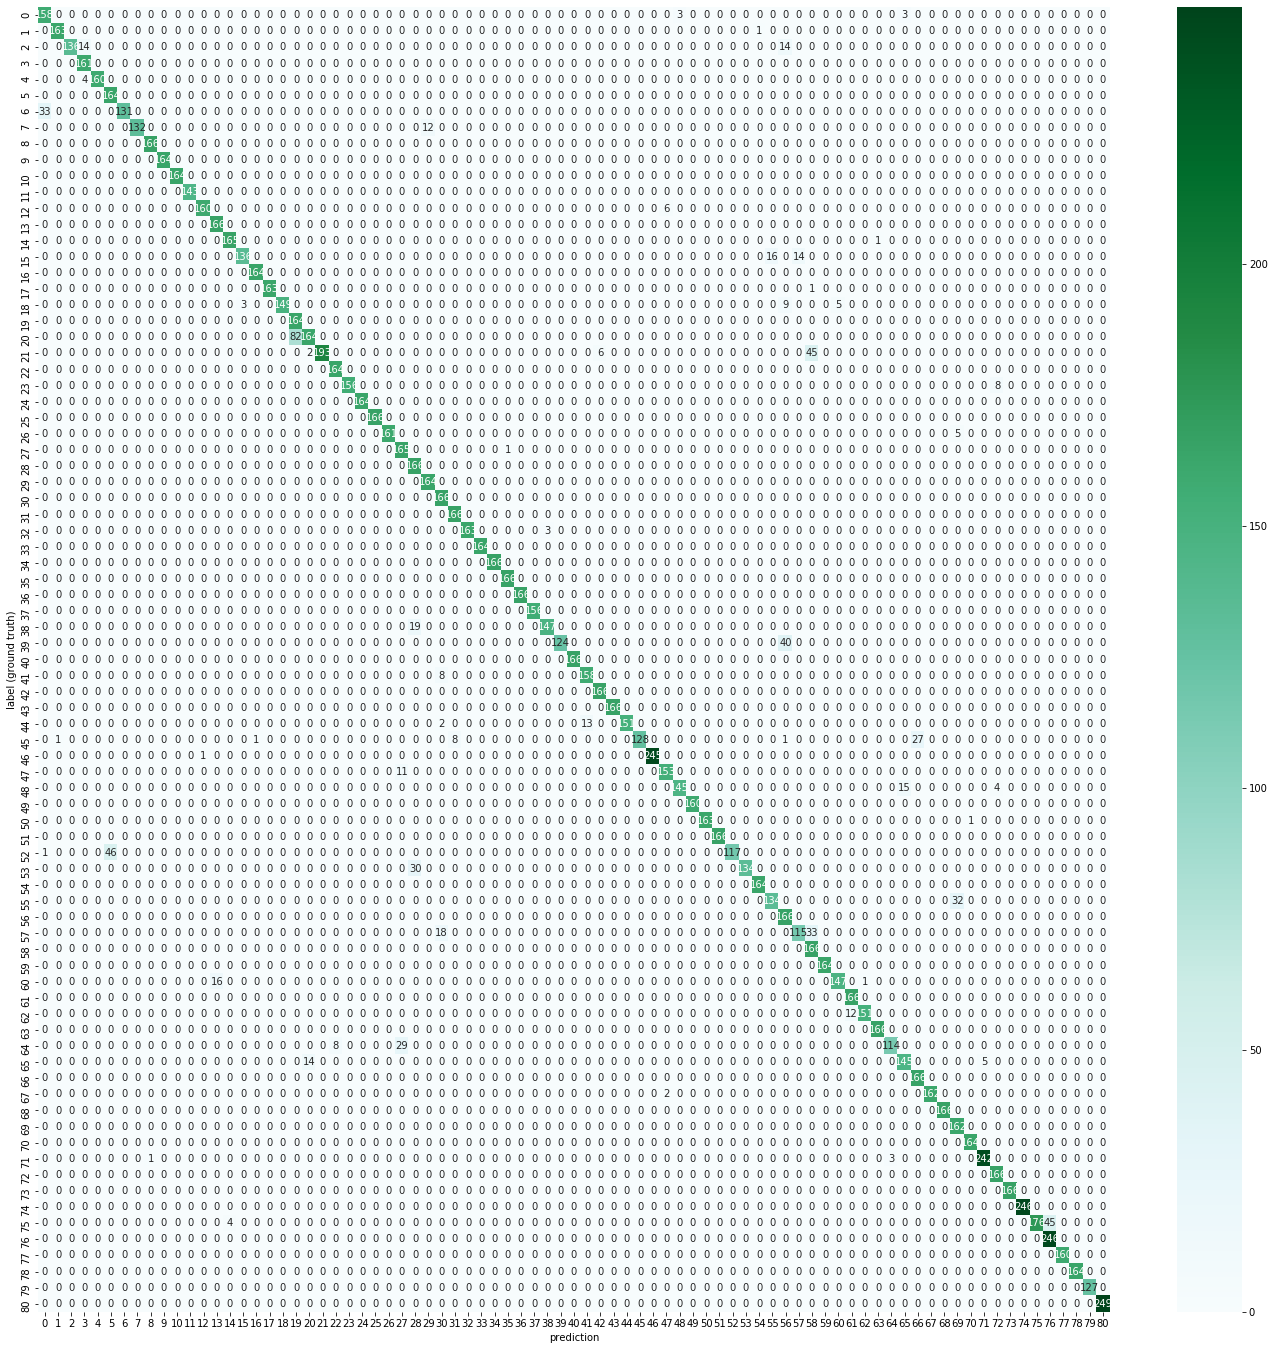

In [39]:
df_cm = pd.DataFrame(confusion_matrix(validation_generator.classes,y_pred))
#print('Confusion Matrix')
#print(confusion_matrix(validation_generator.classes,y_pred))
plt.figure(figsize=(24,24))
sns.heatmap(df_cm,annot=True,cmap='BuGn',fmt="d")
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")

In [64]:
label_map = (train_generator.class_indices)

In [70]:
label_map.keys()

dict_keys(['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry', 'Kaki', 'Kiwi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Maracuja', 'Melon Piel de Sapo', 'Mulberry', 'Nectarine', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Peach Flat', 'Pear', 'Pear Abate', 'Pear Monster', 'Pear Williams', 'Pepino', 'Physalis', 'Physalis with Husk', 'Pineapple', 'Pineapple Mini', 'Pitahaya Red', 'Plum', 'Pomegranate', 'Quince', 'Rambutan', 'Raspberry', 'Salak', 'St

In [72]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred, target_names=label_map.keys()))

Classification Report
                     precision    recall  f1-score   support

     Apple Braeburn       0.82      0.96      0.89       164
     Apple Golden 1       0.99      0.99      0.99       164
     Apple Golden 2       1.00      0.83      0.91       164
     Apple Golden 3       0.90      1.00      0.95       161
 Apple Granny Smith       1.00      0.98      0.99       164
        Apple Red 1       0.78      1.00      0.88       164
        Apple Red 2       1.00      0.80      0.89       164
        Apple Red 3       1.00      0.92      0.96       144
Apple Red Delicious       0.99      1.00      1.00       166
   Apple Red Yellow       1.00      1.00      1.00       164
            Apricot       1.00      1.00      1.00       164
            Avocado       1.00      1.00      1.00       143
       Avocado ripe       0.99      0.96      0.98       166
             Banana       0.91      1.00      0.95       166
         Banana Red       0.98      0.99      0.99       166
 